## Project Overview

This project uses data from the 2024 Stack Overflow Developer Survey to explore which factors influence developer salaries. The goal is to build a predictive model that estimates annual compensation and explain how key variables affect predictions.

Main goals:
- Build a predictive regression model
- Tune and evaluate performance
- Interpret which factors most influence salary using SHAP

The outcome highlights the complexity of real-world salary prediction and demonstrates a complete, explainable data science pipeline.

## Table of Contents
1. [Project Overview](#Project-Overview)
2. [Data Cleaning](#Data-Cleaning)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Modeling and Evaluation](#Modeling-and-Evaluation)
5. [Hyperparameter Tuning](#Hyperparameter-Tuning)
6. [Model Results](#Model-Results)
7. [SHAP Explainability](#SHAP-Explainability)
8. [Final Conclusions](#Final-Conclusions)


## Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
# Modeling and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score


In [3]:
#load the dataset
df= pd.read_csv("survey_results_public.csv")
print(df.head())
print(df.shape)

   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65437 entries, 0 to 65436
Columns: 114 entries, ResponseId to JobSat
dtypes: float64(13), int64(1), object(100)
memory usage: 56.9+ MB


### Dataset Overview

This survey has 114 columns and over 65,000 responses! But many of the columns are:
- free text (hard to use in modeling)
- Multiple-choice questions with messy formatting
- Mostly empty or not useful for predicting salary

So instead of using all 114 columns, I'll pick just a few that are:
- Easy to work with
- Likely to affect salary
- Mostly filled in by respondents

I’ll focus on columns like:
- `Country` – where the developer lives
- `EdLevel` – their highest education level
- `YearsCode` – how many years they’ve been coding
- `Employment` – whether they’re full-time, student, etc.
- `DevType` – what kind of developer they are


In [5]:
for col in df.columns:
    print(col)

ResponseId
MainBranch
Age
Employment
RemoteWork
Check
CodingActivities
EdLevel
LearnCode
LearnCodeOnline
TechDoc
YearsCode
YearsCodePro
DevType
OrgSize
PurchaseInfluence
BuyNewTool
BuildvsBuy
TechEndorse
Country
Currency
CompTotal
LanguageHaveWorkedWith
LanguageWantToWorkWith
LanguageAdmired
DatabaseHaveWorkedWith
DatabaseWantToWorkWith
DatabaseAdmired
PlatformHaveWorkedWith
PlatformWantToWorkWith
PlatformAdmired
WebframeHaveWorkedWith
WebframeWantToWorkWith
WebframeAdmired
EmbeddedHaveWorkedWith
EmbeddedWantToWorkWith
EmbeddedAdmired
MiscTechHaveWorkedWith
MiscTechWantToWorkWith
MiscTechAdmired
ToolsTechHaveWorkedWith
ToolsTechWantToWorkWith
ToolsTechAdmired
NEWCollabToolsHaveWorkedWith
NEWCollabToolsWantToWorkWith
NEWCollabToolsAdmired
OpSysPersonal use
OpSysProfessional use
OfficeStackAsyncHaveWorkedWith
OfficeStackAsyncWantToWorkWith
OfficeStackAsyncAdmired
OfficeStackSyncHaveWorkedWith
OfficeStackSyncWantToWorkWith
OfficeStackSyncAdmired
AISearchDevHaveWorkedWith
AISearchDevWantTo

In [6]:
df.describe()

,ResponseId,CompTotal,WorkExp,JobSatPoints_1,JobSatPoints_4,JobSatPoints_5,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,ConvertedCompYearly,JobSat
count,65437.000000,3.374000e+04,29658.000000,29324.000000,29393.000000,29411.000000,29450.000000,29448.00000,29456.000000,29456.000000,29450.000000,29445.000000,2.343500e+04,29126.000000
mean,32719.000000,2.963841e+145,11.466957,18.581094,7.522140,10.060857,24.343232,22.96522,20.278165,16.169432,10.955713,9.953948,8.615529e+04,6.935041
std,18890.179119,5.444117e+147,9.168709,25.966221,18.422661,21.833836,27.089360,27.01774,26.108110,24.845032,22.906263,21.775652,1.867570e+05,2.088259
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000
25%,16360.000000,6.000000e+04,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,3.271200e+04,6.000000
50%,32719.000000,1.100000e+05,9.000000,10.000000,0.000000,0.000000,20.000000,15.00000,10.000000,5.000000,0.000000,0.000000,6.500000e+04,7.000000
75%,49078.000000,2.500000e+05,16.000000,22.000000,5.000000,10.000000,30.000000,30.00000,25.000000,20.000000,10.000000,10.000000,1.079715e+05,8.000000
max,65437.000000,1.000000e+150,50.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,1.625660e+07,10.000000


### Target Variable: `ConvertedCompYearly`

For this project, I want to predict how much money a developer makes per year. The column `ConvertedCompYearly` tells us each person's total yearly salary (converted to USD), so it works well as the target for a regression model.

Next, I’ll clean the salary column and explore its distribution before moving on to feature selection.


### Step 1: Subset Data

In [7]:
#Choosing the relevant columns
cols= ['Country', 'EdLevel', 'YearsCode', 'Employment', 'DevType', 'ConvertedCompYearly']
df_subset=df[cols].copy()
df_subset

,Country,EdLevel,YearsCode,Employment,DevType,ConvertedCompYearly
0,United States of America,Primary/elementary school,NaN,"Employed, full-time",NaN,NaN
1,United Kingdom of Great Britain and Northern I...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,"Employed, full-time","Developer, full-stack",NaN
2,United Kingdom of Great Britain and Northern I...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",37,"Employed, full-time",Developer Experience,NaN
3,Canada,Some college/university study without earning ...,4,"Student, full-time","Developer, full-stack",NaN
4,Norway,"Secondary school (e.g. American high school, G...",9,"Student, full-time","Developer, full-stack",NaN
...,...,...,...,...,...,...
65432,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,"Employed, full-time",Blockchain,NaN
65433,NaN,NaN,NaN,"Employed, full-time",NaN,NaN
65434,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",9,"Employed, full-time","Developer, mobile",NaN
65435,Germany,"Secondary school (e.g. American high school, G...",5,"Employed, full-time","Developer, back-end",NaN


In [8]:
df_subset.isnull().sum()

Country                 6507
EdLevel                 4653
YearsCode               5568
Employment                 0
DevType                 5992
ConvertedCompYearly    42002
dtype: int64

### Handling Missing Salary Values

The `ConvertedCompYearly` column is the target variable for this project, it's what we're trying to predict. Since machine learning models can't learn from missing target values, we need to remove any rows where the salary is not provided.

Out of over 65,000 survey responses, only about 23,000 respondents answered the salary question. While this means dropping a large number of rows, it's a necessary step to ensure we are only training our model on complete and usable data.

We’ll now filter the dataset to include only the rows where `ConvertedCompYearly` is not null.


In [9]:
df_subset=df_subset[df_subset['ConvertedCompYearly'].notnull()]
df_subset

,Country,EdLevel,YearsCode,Employment,DevType,ConvertedCompYearly
72,Pakistan,"Secondary school (e.g. American high school, G...",3,"Employed, full-time;Student, full-time;Indepen...",Data scientist or machine learning specialist,7322.0
374,Austria,"Professional degree (JD, MD, Ph.D, Ed.D, etc.)",12,"Employed, full-time",Academic researcher,30074.0
379,Turkey,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",15,"Employed, full-time",Data scientist or machine learning specialist,91295.0
385,France,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",27,"Independent contractor, freelancer, or self-em...","Developer, back-end",53703.0
389,United States of America,Some college/university study without earning ...,7,"Employed, full-time;Student, part-time",Student,110000.0
...,...,...,...,...,...,...
41180,Sweden,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",6,"Employed, full-time","Developer, embedded applications or devices",44640.0
41184,United States of America,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",36,"Employed, full-time",Project manager,170000.0
41185,United States of America,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,"Employed, full-time","Developer, full-stack",116844.0
41186,United States of America,Some college/university study without earning ...,5,"Student, full-time;Employed, part-time","Developer, full-stack",12000.0


In [10]:
df_subset.isnull().sum()

Country                 0
EdLevel                 0
YearsCode              47
Employment              0
DevType                32
ConvertedCompYearly     0
dtype: int64

### Handling Remaining Missing Values

After dropping rows with missing salary data, I checked the rest of the dataset for missing values. Only a few rows are missing values in `YearsCode` and `DevType`, which are important features for modeling.

Since the number of missing rows is very small (less than 0.2% of the dataset), I decided to drop them instead of filling or guessing the values. This helps keep the dataset clean and avoids introducing any unwanted bias.

In [11]:
df_subset= df_subset.dropna()

In [12]:
df_subset.isnull().sum().sum() 

0

### Handling Data Types For Usability

In [13]:
df_subset.dtypes

Country                 object
EdLevel                 object
YearsCode               object
Employment              object
DevType                 object
ConvertedCompYearly    float64
dtype: object

In [14]:
df_subset.nunique()

Country                 166
EdLevel                   8
YearsCode                52
Employment               55
DevType                  34
ConvertedCompYearly    6103
dtype: int64

In [15]:
for col in df_subset.columns:
    print(f"\n-----{col}-----")
    print(df_subset[col].unique())


-----Country-----
['Pakistan' 'Austria' 'Turkey' 'France' 'United States of America'
 'United Kingdom of Great Britain and Northern Ireland' 'Bulgaria'
 'Greece' 'Brazil' 'Germany' 'Italy' 'Ukraine' 'Russian Federation'
 'South Africa' 'Czech Republic' 'Canada' 'Iran, Islamic Republic of...'
 'Dominican Republic' 'Switzerland' 'Belgium' 'Peru' 'Bolivia' 'Morocco'
 'India' 'Luxembourg' 'Georgia' 'Saudi Arabia' 'Ireland' 'Romania' 'Spain'
 'Cyprus' 'Paraguay' 'Lithuania' 'Netherlands' 'Slovenia' 'Singapore'
 'Venezuela, Bolivarian Republic of...' 'Japan' 'Latvia' 'Sweden'
 'Costa Rica' 'Poland' 'Norway' 'Portugal' 'Finland' 'Israel' 'Nicaragua'
 'Serbia' 'Croatia' 'Hungary' 'Bangladesh' 'Indonesia' 'Denmark'
 'Bosnia and Herzegovina' 'Mexico' 'Philippines' 'Thailand' 'Slovakia'
 'Ecuador' 'Argentina' 'Algeria' 'Kazakhstan' 'Malaysia' 'Zimbabwe'
 'Afghanistan' 'Malta' 'Belarus' 'Colombia' 'Egypt' 'Montenegro'
 'Australia' 'Isle of Man' 'New Zealand' 'Palestine' 'Armenia' 'Maldives'
 'Uni

### Converting `YearsCode` to Numeric:

The `YearsCode` column represents how many years the respondent has been coding, but it's stored as text. It also includes special values like "Less than 1 year" and "More than 50 years".

To prepare this column for modeling, I replaced these values with numeric equivalents (0 and 51), and then converted the entire column to a numeric data type.


In [16]:
#Replace text values with numbers
df_subset['YearsCode']=df_subset['YearsCode'].replace({'Less than 1 year':'0',
                                                       'More than 50 years':'51'})
#convert column from string to numeric
df_subset['YearsCode']= pd.to_numeric(df_subset['YearsCode'], errors='coerce')

C:\Users\prati\AppData\Local\Temp\ipykernel_19340\3374521321.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['YearsCode']=df_subset['YearsCode'].replace({'Less than 1 year':'0',
C:\Users\prati\AppData\Local\Temp\ipykernel_19340\3374521321.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['YearsCode']= pd.to_numeric(df_subset['YearsCode'], errors='coerce')


In [17]:
df_subset.dtypes

Country                 object
EdLevel                 object
YearsCode                int64
Employment              object
DevType                 object
ConvertedCompYearly    float64
dtype: object

### Encoding Categorical Features

To use the categorical columns in our regression model, we need to convert them into numeric format. I used one-hot encoding with `pd.get_dummies()` to convert the following columns:
- `Country`
- `EdLevel`
- `Employment`
- `DevType`

One-hot encoding creates a new binary column for each category in a feature. I set `drop_first=True` to avoid multicollinearity by dropping the first category from each set.

The resulting dataset now contains only numeric values and is ready for model training.


In [18]:
#One-Hot Encode selected categorical columns
df_encoded= pd.get_dummies(df_subset, columns=['Country', 'EdLevel', 'Employment', 'DevType'], drop_first=True)
#find shape
print(df_encoded.shape)

(23363, 261)


### Data Transformation Complete

After selecting and cleaning the relevant columns, I applied one-hot encoding to all categorical variables. The final dataset now contains only numeric columns and is ready for modeling.

We now have 23,363 rows and 261 columns - a manageable size that includes all the key features needed to understand and predict developer salary.


## Exploratory Data Analysis

### Project Questions

Before modeling, I want to explore the following questions using visual analysis and machine learning:

1. What are the most important factors that influence a developer's salary?
2. How does salary vary across different education levels, countries, and job types?
3. Can I build a machine learning model to predict a developer's salary based on their background and work profile?

The next step is to perform some visual EDA (exploratory data analysis) to look for trends and patterns in the data.


### Salary Distribution

Before building the model, I visualized the distribution of developer salaries to better understand the target variable. 

C:\Users\prati\AppData\Local\Temp\ipykernel_19340\312984284.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x/10000)}K' for x in ax.get_xticks()])


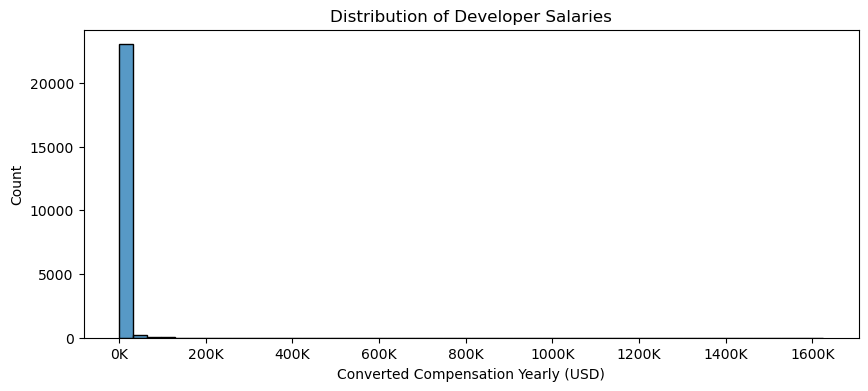

In [19]:
plt.figure(figsize=(10,4));
sns.histplot(df_subset['ConvertedCompYearly'], bins=50)
plt.title('Distribution of Developer Salaries')
plt.xlabel('Converted Compensation Yearly (USD)')
plt.ylabel('Count')
ax=plt.gca()
ax.set_xticklabels([f'{int(x/10000)}K' for x in ax.get_xticks()])
plt.savefig("salary-distribution.png", dpi=300, bbox_inches='tight');

#### Conclusion
As expected, the distribution is highly right-skewed, most salaries fall below $200,000, with a small number of very high earners pulling the tail to the right. This skewness is typical in real-world income data, where a few individuals earn significantly more than the average.

This plot confirms the need for using models that can handle non-linear relationships or skewed distributions.

### Bar Plot: Average Salary by Education Level

Education level is often assumed to influence earning potential. This chart shows the average salary for each education group based on survey responses.

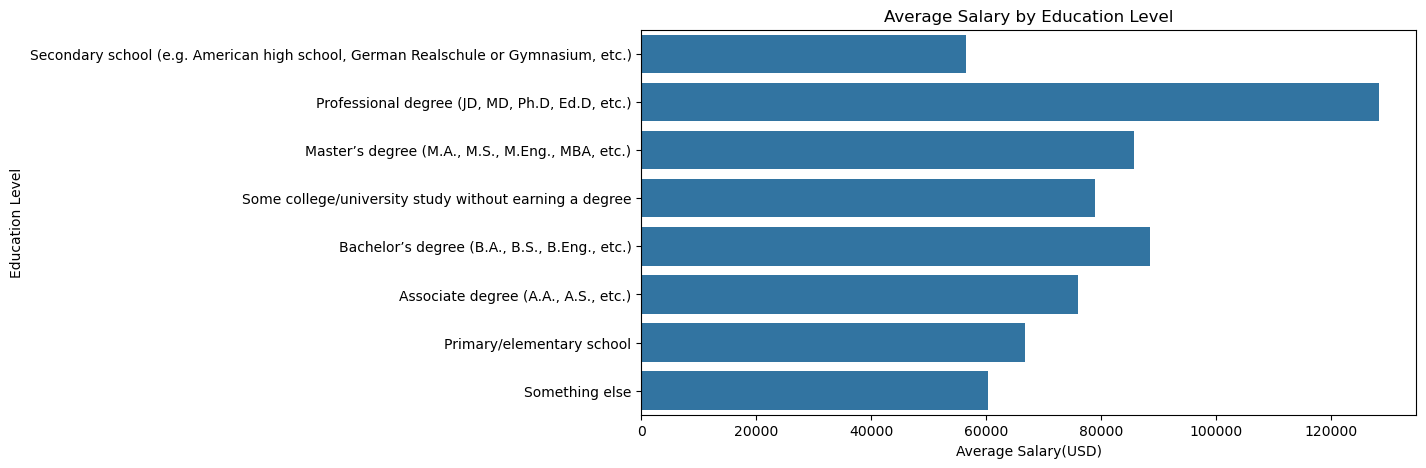

In [20]:
plt.figure(figsize=(10,5));
sns.barplot(data=df_subset, x='ConvertedCompYearly', y='EdLevel', estimator=np.mean, errorbar=None)
plt.title('Average Salary by Education Level')
plt.xlabel('Average Salary(USD)')
plt.ylabel('Education Level')
plt.savefig("salary-by-education.png", dpi=300, bbox_inches='tight');

#### Conclusion
As expected, those with advanced degrees such as Master’s or Doctoral degrees generally report higher average salaries. Interestingly, some groups like professional degree holders and even those with "some college" experience show competitive or even higher earnings. This may reflect other factors like job type, skills, or years of experience.

Overall, this confirms that `EdLevel` is an important feature for our salary prediction model.

### Scatter Plot: Salary by Education Level

To understand the relationship between experience and compensation, I created a scatter plot of salary versus years of coding experience.

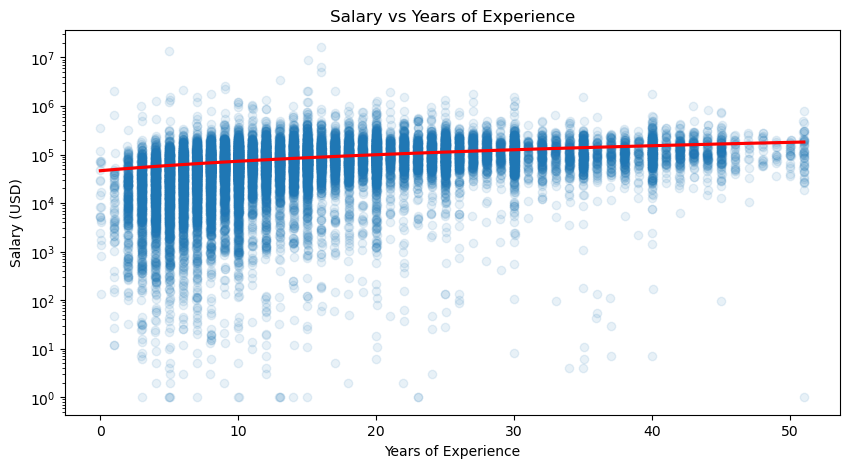

In [21]:
plt.figure(figsize=(10,5));
sns.regplot(data=df_subset, x='YearsCode', y='ConvertedCompYearly', x_jitter=0.04, scatter_kws={'alpha':1/10}, line_kws={'color':'red'})
plt.yscale('log')
plt.title('Salary vs Years of Experience')
plt.xlabel('Years of Experience')
plt.ylabel('Salary (USD)')
plt.savefig("salary-vs-exp-scatter.png", dpi=300, bbox_inches='tight');


#### Conclusion

I expected to see a strong link between experience and salary, but the plot shows a lot of variation. Some developers with just a few years of experience earn very high salaries, while others with decades of experience earn much less.

This tells me that experience alone doesn't explain salary well. It probably works together with other things like job type, education, and country.

That’s why I’ll use models like decision trees and random forests. These models can handle complex patterns.


##  Modeling and Evaluation

### 🔍 Model 1: Linear Regression (Baseline)

To start, I used a simple linear regression model. This gives me a baseline to compare other models against. Linear regression assumes a straight-line relationship between features and the target.

After training and testing, I will compare the model’s error and R² score to see how well it performs.

#### Step 1: Split Target and Features Matrix

In [22]:
y= df_encoded['ConvertedCompYearly'] #set target variable
X= df_encoded.drop('ConvertedCompYearly', axis=1)

#### Step 2: Train Test Split

In [23]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

#### Step 3: Train Linear Regression Model

In [24]:
lr_model= LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

#### Predict Linear Regression Model 

In [25]:
train_lr_pred = lr_model.predict(X_train)
train_r2= lr_model.score(X_train, y_train)
print(f'Linear Model training r^2: {train_r2:.3f}')
train_rmse= root_mean_squared_error(y_train, train_lr_pred)
print(f'Linear Model training RMSE: {train_rmse:.2f}')

Linear Model training r^2: 0.107
Linear Model training RMSE: 189626.43


In [26]:
test_lr_pred= lr_model.predict(X_test)
test_r2= lr_model.score(X_test, y_test)
print(f'Linear Model test r^2:{test_r2:.3f}')
test_rmse= root_mean_squared_error(y_test, test_lr_pred)
print(f'Linear Model test RMSE: {test_rmse:.2f}')

Linear Model test r^2:0.127
Linear Model test RMSE: 108284.76


#### Model 1 Results: Linear Regression

I trained a linear regression model to predict salary using the features I selected. The model's performance is quite weak:

- R² Score (Train): 0.107
- R² Score (Test): 0.127
- RMSE (Train): ~$189,000
- RMSE (Test): ~$108,000

This means the model is only explaining about 10–13% of the variation in salaries — and the prediction error(RMSE) is very high.

The results suggest that linear regression is not be the right choice for this problem, probably because:
- Salary is influenced by complex, non-linear interactions between features
- The data may include outliers or high variance that linear models can't handle well

#### Next Step: Trying Tree-Based Models

To improve performance, I’ll try **Decision Tree Regressor** to capturing non-linear relationships and noisy data like Salary.

In [27]:
dt_model=DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train) #train decision tree model

DecisionTreeRegressor(random_state=42)

In [28]:
train_dt_pred= dt_model.predict(X_train)
train_dt_r2= dt_model.score(X_train, y_train)
print(f'Train Decision Tree r^2: {train_dt_r2:.3f}')
train_dt_rmse= root_mean_squared_error(y_train, train_dt_pred)
print(f'Train Decision Tree RMSE:{train_dt_rmse:.2f}')

Train Decision Tree r^2: 0.955
Train Decision Tree RMSE:42599.68


In [29]:
test_dt_pred= dt_model.predict(X_test)
test_dt_r2= dt_model.score(X_test, y_test)
print(f'Test Decision Tree r^2: {test_dt_r2:.3f}')
test_dt_rmse=root_mean_squared_error(y_test, test_dt_pred)
print(f'Test Decision Tree RMSE: {test_dt_rmse:.3f}')

Test Decision Tree r^2: -1.093
Test Decision Tree RMSE: 167671.524


#### Model 2 Results : Decision Tree Regressor

The Decision Tree Regressor achieved a very low RMSE on the training data and a very high R² (0.955), which shows it learned the training set extremely well.

However, the test results were poor:
- The R² score was **negative**, meaning the model did worse than simply predicting the average salary for everyone.
- The **test RMSE was over $167,000**, indicating very large errors on new data.

This confirms that the model is **overfitting** ; it performs well on the training set but fails to generalize to unseen data.

#### Next Step: Trying Random Forest Regressor

To fix this, I will try a **Random Forest Regressor**, which builds many trees and averages their predictions.


In [30]:
rf_model= RandomForestRegressor(n_estimators=100, random_state=42) #builds 100 trees and averages their predictions
rf_model.fit(X_train, y_train) #train random forest model

RandomForestRegressor(random_state=42)

In [31]:
train_rf_pred= rf_model.predict(X_train)
train_rf_r2= rf_model.score(X_train, y_train)
print(f'Train Random Forest r^2: {train_rf_r2:.3f}')
train_rf_rmse= root_mean_squared_error(y_train, train_rf_pred)
print(f'Train Random Forest RMSE: {train_rf_rmse:.3f}')

Train Random Forest r^2: 0.810
Train Random Forest RMSE: 87452.155


In [32]:
test_rf_pred= rf_model.predict(X_test)
test_rf_r2= rf_model.score(X_test, y_test)
print(f'Test Random Forest r^2: {test_rf_r2:.3f}')
test_rf_rmse= root_mean_squared_error(y_test, test_rf_pred)
print(f'Test Random Forest RMSE: {test_rf_rmse:.3f}')

Test Random Forest r^2: -0.236
Test Random Forest RMSE: 128835.856


### Model 3 Results: Random Forest Regressor

The Random Forest model performed much better than the decision tree on training data (R² = 0.81), showing it learned useful patterns.

However, the test results were disappointing:
- R² Score = -0.236 (worse than predicting the average salary)
- RMSE ≈ $128,800 (still a large error)

This suggests the model is **still overfitting** — possibly due to the high variance and noise in the salary data.

### Feature Importance (Random Forest)

Before tuning the model, I looked at which features were most influential in the Random Forest. This helps guide future steps, like:
- Removing unimportant or noisy features
- Interpreting model behavior

The plot below shows the top 10 features based on their importance scores.


In [33]:
#Get feature importances
importances= rf_model.feature_importances_
features= X_train.columns

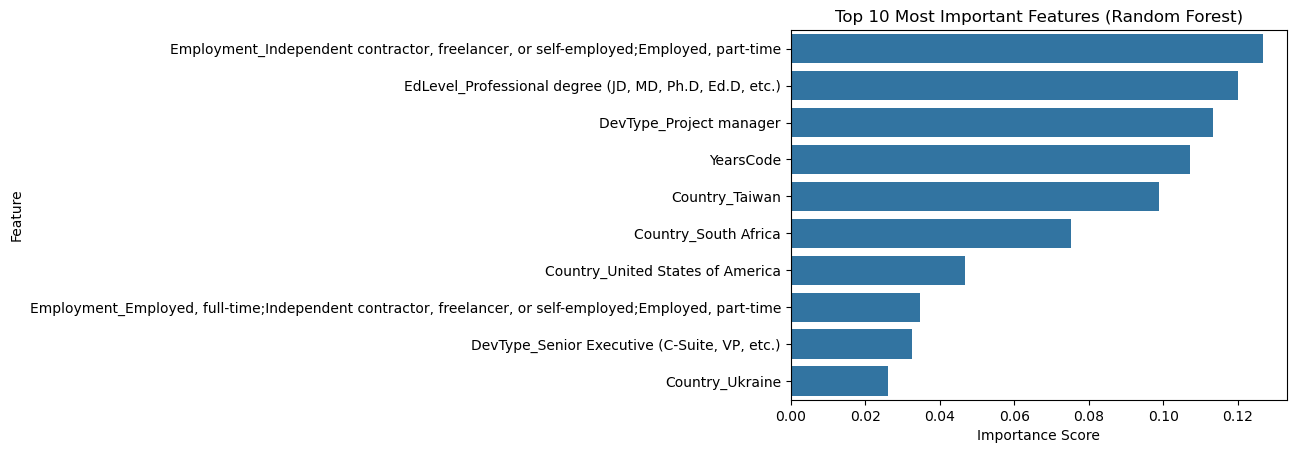

In [34]:
#Create a dataframe
feat_df=pd.DataFrame({'Feature':features, 'Importance':importances}).sort_values(by='Importance', ascending=False)
feat_df_subset=feat_df[:10]
sns.barplot(data=feat_df_subset, x='Importance', y='Feature')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.savefig("rf-feature-importance.png", dpi=300, bbox_inches='tight');

#### Interpreting Feature Importance (Random Forest)

After training the Random Forest model, I examined which features contributed most to the predictions. The plot above shows the top 10 most important features. Some key takeaways:

- **Employment type**, **Professional degree**, and **Project Manager role** were among the most influential.
- **Years of experience** also had strong predictive power.
- Interestingly, specific countries like **Taiwan**, **South Africa**, and **USA** appeared as important indicators which may reflect global differences in salary norms.

This analysis highlights the most impactful features in the dataset and suggests where simplification might be most effective.

In [35]:
#Get the top 10 features from feature importance dataframe
top_features= list(feat_df_subset['Feature'])
#Subset Training and Test dataset
X_train_top= X_train[top_features]
X_test_top=X_test[top_features]

In [36]:
rf_model_top=RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_top.fit(X_train_top, y_train) #train random forest model

RandomForestRegressor(random_state=42)

In [37]:
train_rf_model_top_pred= rf_model_top.predict(X_train_top)
train_rf_model_top_r2= rf_model_top.score(X_train_top, y_train)
train_rf_model_top_rmse= root_mean_squared_error(y_train, train_rf_model_top_pred)

test_rf_model_top_pred= rf_model_top.predict(X_test_top)
test_rf_model_top_r2= rf_model_top.score(X_test_top, y_test)
test_rf_model_top_rmse= root_mean_squared_error(y_test, test_rf_model_top_pred)

print(f' Train R^2 for Top 10 Features:{train_rf_model_top_r2:.3f}')
print(f' Train RMSE for Top 10 Features:{train_rf_model_top_rmse:.3f}')
print(f' Test R^2 for Top 10 Features:{test_rf_model_top_r2:.3f}')
print(f' Test RMSE for Top 10 Features:{test_rf_model_top_rmse:.3f}')

 Train R^2 for Top 10 Features:0.668
 Train RMSE for Top 10 Features:115613.229
 Test R^2 for Top 10 Features:0.095
 Test RMSE for Top 10 Features:110246.058


#### Conclusion: Random Forest with Top 10 Features

After correcting my prediction code, the model showed:

- R² Score (Train): 0.668
- R² Score (Test): 0.095
- RMSE (Train): ~ $115,600 
- RMSE (Test): ~$110,200

The model performs well on the training data but struggles to generalize. Despite using only the top 10 features, the test R² remains low, indicating the model cannot fully capture the complexity of salary prediction from these features alone.

### Next Step: Tune the Model

To reduce overfitting and improve generalization, I’ll now try training the subsetted data above with a Random Forest model with **limited tree depth** and compare results.


## Hyperparameter Tuning

In [38]:
param_grid={ 'max_depth':[5,10], 'min_samples_split':[5,10],'min_samples_leaf':[2,4]}
#Run GridSearchCV
grid_search_model=GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, random_state=42),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error') # Maximize lower RMSE
grid_search_model.fit(X_train_top, y_train) # Fit on training data

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [5, 10], 'min_samples_leaf': [2, 4],
                         'min_samples_split': [5, 10]},
             scoring='neg_root_mean_squared_error')

In [39]:
#View Best Parameters
print("Best Parameters:", grid_search_model.best_params_)
best_model= grid_search_model.best_estimator_

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [40]:
train_best_pred= best_model.predict(X_train_top)
train_best_r2= best_model.score(X_train_top, y_train)
train_best_rmse= root_mean_squared_error(y_train, train_best_pred)

test_best_pred= best_model.predict(X_test_top)
test_best_r2= best_model.score(X_test_top, y_test)
test_best_rmse= root_mean_squared_error(y_test, test_best_pred)

print(f"Train R^2: {train_best_r2:.3f}")
print(f"Train RMSE: {train_best_rmse:.3f}")
print(f"Test R^2: {test_best_r2:.3f}")
print(f"Test RMSE: {test_best_rmse:.3f}")

Train R^2: 0.179
Train RMSE: 181855.426
Test R^2: 0.059
Test RMSE: 112414.118


##  Model Results

#### Conclusion: GridSearchCV-Tuned Random Forest (Top 10 Features)

After running GridSearchCV, the best parameters were:
- `max_depth=5`
- `min_samples_split=10`
- `min_samples_leaf=4`

These settings led to an underfit model:
- Train R²: 0.179
- Test R²: 0.059
- Test RMSE: $112,414

Both train and test R² are low, RMSE is high: model is underfit.

Next, I will explore a slightly wider parameter grid to find a better balance between complexity and generalization.

In [41]:
param_grid = {
    'max_depth': [15,20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
#Run GridSearchCV
grid_search_model=GridSearchCV(estimator=RandomForestRegressor(n_estimators=100, random_state=42),
                         param_grid=param_grid,
                         scoring='neg_root_mean_squared_error') # Maximize lower RMSE
grid_search_model.fit(X_train_top, y_train) # Fit on training data

GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [15, 20, 25],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_root_mean_squared_error')

In [42]:
#View Best Parameters
print("Best Parameters:", grid_search_model.best_params_)
best_model= grid_search_model.best_estimator_

Best Parameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [43]:
train_best_pred= best_model.predict(X_train_top)
train_best_r2= best_model.score(X_train_top, y_train)
train_best_rmse= root_mean_squared_error(y_train, train_best_pred)

test_best_pred= best_model.predict(X_test_top)
test_best_r2= best_model.score(X_test_top, y_test)
test_best_rmse= root_mean_squared_error(y_test, test_best_pred)

print(f"Train R^2: {train_best_r2:.3f}")
print(f"Train RMSE: {train_best_rmse:.3f}")
print(f"Test R^2: {test_best_r2:.3f}")
print(f"Test RMSE: {test_best_rmse:.3f}")

Train R^2: 0.188
Train RMSE: 180841.288
Test R^2: 0.045
Test RMSE: 113219.707


## SHAP Explainability

### SHAP Values: Explaining the Model

Even though my model's R² was low, SHAP helps explain what it **did** learn.

The plots below show:
- Which features influenced the salary predictions the most
- Whether each feature **increased** or **decreased** the predicted salary
- How the **range of values** for each feature affected the outcome

This adds interpretability and supports understanding of the dataset's most meaningful patterns, even when model accuracy is limited.


In [44]:
X_train_top=X_train_top.astype(float)
explainer=shap.Explainer(best_model, X_train_top) #create TreeExplainer
shap_values=explainer(X_train_top) #compute SHAP for training set

 99%|===================| 18553/18690 [01:45<00:00]        

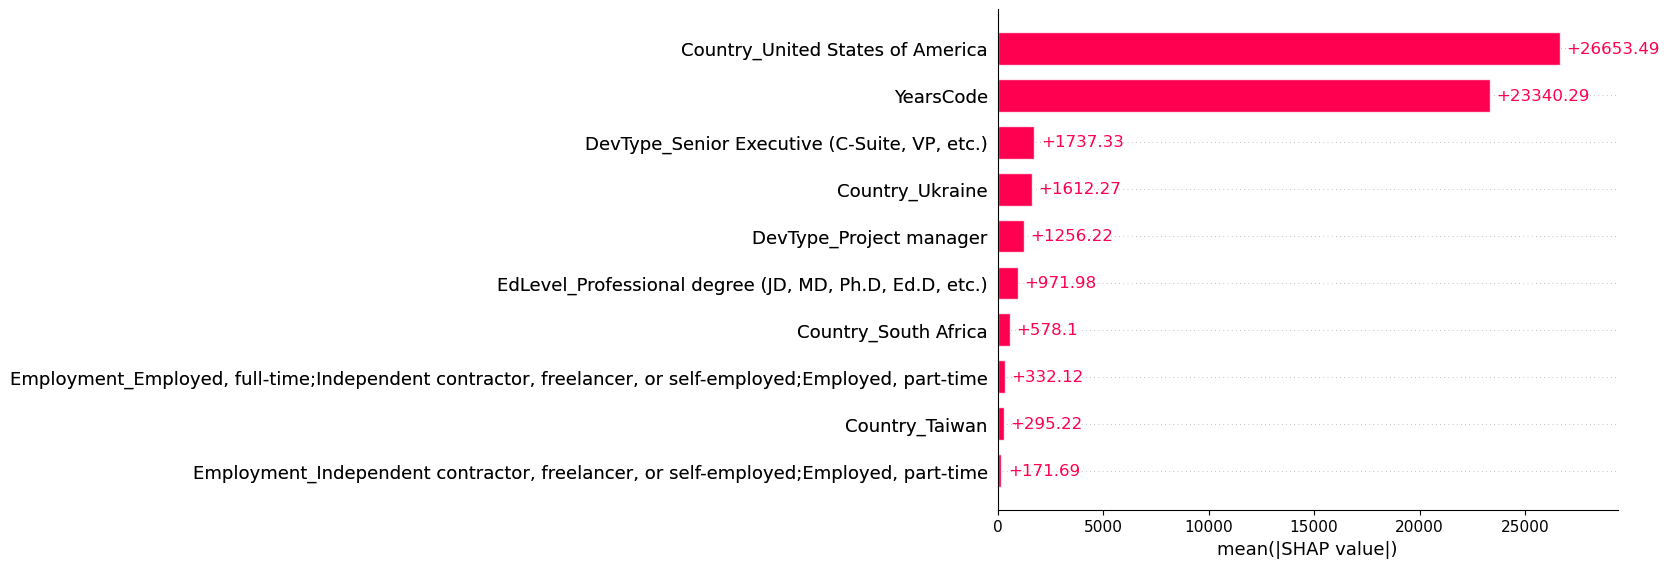

In [52]:
fig=shap.plots.bar(shap_values, show=False) # plot overall importance of features
plt.savefig("shap-bar-plot.png", dpi=300, bbox_inches='tight'); #Save the figure using Matplotlib


#### SHAP Insights

SHAP showed that:
- Developers in the United States or with high experience consistently had higher predicted salaries.
- DevType: Senior Executive and Country: Ukraine also showed strong upward effects.
- Employment types like part-time or freelance had less predictive influence.

Even with low model accuracy, SHAP helped uncover interpretable signals in the data.

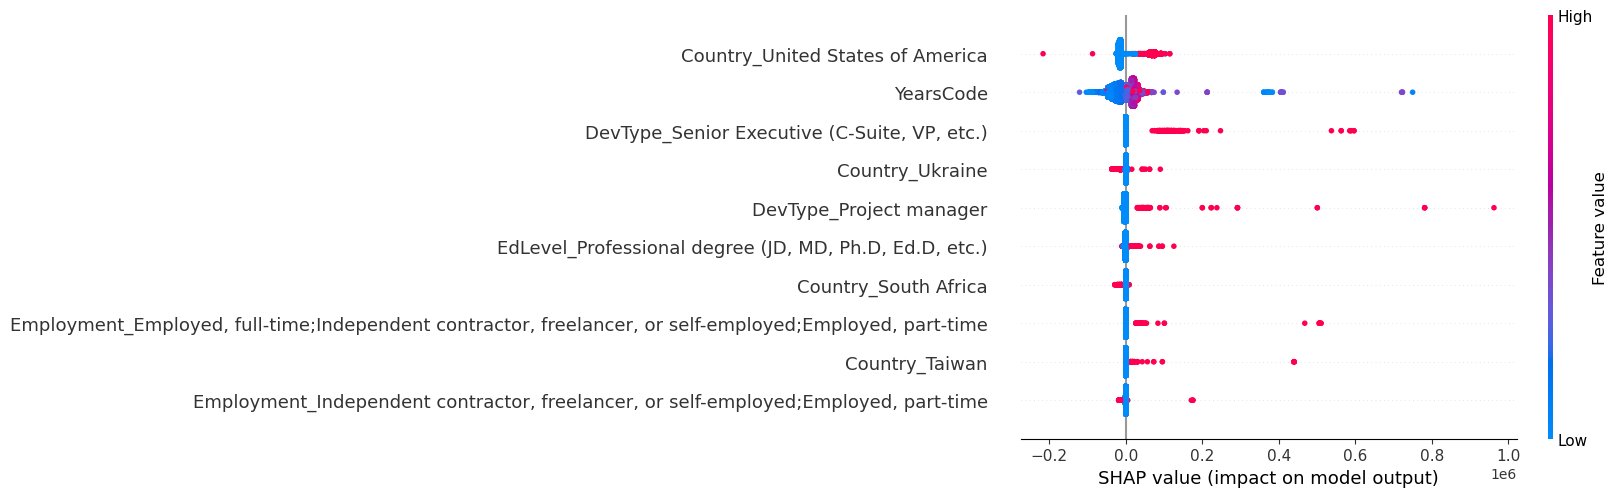

In [53]:
fig=shap.plots.beeswarm(shap_values, show=False) # plot how feature values push predictions
plt.savefig("shap-beeswarm.png", dpi=300, bbox_inches='tight'); 

#### SHAP Value Interpretation

SHAP values help explain how each feature in the model impacts the predicted salary.

- The **bar plot** below shows the average influence of each feature.
- The **beeswarm plot** gives a more detailed view of how different values of those features increased or decreased the predictions.

For example:
- Being located in the **United States** or having more **years of coding experience** consistently increased predicted salaries.
- Features like **DevType: Senior Executive** and **Country: Ukraine** also showed strong upward influence.
- Categories like **part-time or freelance employment** had lower impact and mixed directionality.

These insights help understand which signals the model found valuable .

## Final Conclusions

This project explored the challenge of predicting developer salaries using the 2024 StackOverflow Developer Survey.

### 🔍 Key Steps Completed:
- Cleaned and subsetted the survey data to focus on numeric and meaningful predictors
- Built and compared baseline models: **Linear Regression**, **Decision Tree**, and **Random Forest**
- Tuned Random Forest with **GridSearchCV** to reduce overfitting
- Selected **top 10 most important features** for simplified, interpretable modeling
- Used **SHAP values** for model explainability

### 📉 Final Model Performance:
- **Train R²**: 0.188
- **Test R²**: 0.045
- **Test RMSE**: ~$113,219

While predictive performance remained low due to high noise and missing factors in the data, the project demonstrates a complete, real-world data science workflow:
- Iterative modeling
- Hyperparameter tuning
- Feature importance interpretation
- Individual prediction explainability using SHAP

### ⚠️ Limitations

- The dataset lacks features like job title specificity, company size, or bonus structure.
- Salary is self-reported and varies widely.
- Some influential factors (negotiation skill, work history) aren’t captured in survey form.

Because of this, even the tuned model explained only a small portion of salary variation.
